In [3]:
# @title Ячейка 1: Импорт библиотек и настройка окружения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Модели
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Метрики и утилиты
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


Подготавливаю данные с учетом специфики алгоритма решающих деревьев:

1.  **Отсутствие масштабирования:** Намеренно пропускаю нормализацию/стандартизацию. Деревья инвариантны к монотонным преобразованиям признаков, так как поиск порога $t$ для разбиения $x_j \leq t$ зависит только от порядка сортировки значений, а не от их абсолютной величины.
2.  **Label Encoding:** Кодирую категориальные признаки простыми числами. Для деревьев это допустимо (в отличие от линейных моделей), так как алгоритм способен изолировать конкретную категорию $c$ через серию последовательных разбиений, даже если введенный порядок (0, 1, 2...) не имеет физического смысла.

In [4]:
# @title Ячейка 2: Загрузка и Подготовка данных (Бейзлайн)

# 1. Загрузка
try:
    df_cls = pd.read_csv('Train.csv')
    df_reg = pd.read_csv('KAG_energydata_complete.csv')
except:
    print("Ошибка загрузки файлов.")

# 2. Предобработка для Деревьев
# Деревьям НЕ нужен Scaling. Но им нужны числа вместо строк.
# Использую LabelEncoding для бейзлайна (деревья нормально с ним работают,так как могут разбить "Профессию > 2", отделив одну группу от другой)

#  Классификация
df_cls_tree = df_cls.copy()
df_cls_tree.drop(['ID'], axis=1, inplace=True, errors='ignore')

# Заполнение пропусков (мода/медиана)
for col in df_cls_tree.columns:
    if df_cls_tree[col].dtype == 'object':
        df_cls_tree[col] = df_cls_tree[col].fillna(df_cls_tree[col].mode()[0])
    else:
        df_cls_tree[col] = df_cls_tree[col].fillna(df_cls_tree[col].median())

# Label Encoding
le_dict = {}
for col in df_cls_tree.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_cls_tree[col] = le.fit_transform(df_cls_tree[col])
    le_dict[col] = le

X_cls = df_cls_tree.drop('Segmentation', axis=1)
y_cls = df_cls_tree['Segmentation']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# --- Регрессия ---
df_reg_tree = df_reg.copy()
df_reg_tree.drop(['date'], axis=1, inplace=True, errors='ignore')

X_reg = df_reg_tree.drop('Appliances', axis=1)
y_reg = df_reg_tree['Appliances']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные готовы..")

Данные готовы..


In [5]:
# @title Ячейка 3: Обучение бейзлайна (Unconstrained Trees)
# Обучаем деревья без ограничения глубины (max_depth=None)

# 1. Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_cls, y_train_cls)

# 2. Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_reg, y_train_reg)

print("Глубина обученного дерева классификации:", tree_clf.get_depth())
print("Глубина обученного дерева регрессии:", tree_reg.get_depth())
print("Количество листьев (Reg):", tree_reg.get_n_leaves())

Глубина обученного дерева классификации: 26
Глубина обученного дерева регрессии: 45
Количество листьев (Reg): 8716


In [6]:
# @title Ячейка 4: Оценка бейзлайна и Демонстрация переобучения

def evaluate_model(model, X_train, y_train, X_test, y_test, task='cls'):
    if task == 'cls':
        # Train метрики
        y_train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)

        # Test метрики
        y_test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy:  {test_acc:.4f}")
        print(f"Test F1-Score:  {test_f1:.4f}")
        return test_acc, test_f1
    else:
        # Train метрики
        y_train_pred = model.predict(X_train)
        train_r2 = r2_score(y_train, y_train_pred)

        # Test метрики
        y_test_pred = model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"Train R2: {train_r2:.4f}")
        print(f"Test R2:  {test_r2:.4f}")
        print(f"Test MAE: {test_mae:.2f}")
        return test_mae, test_r2

print("--- CLASSIFICATION (Decision Tree Baseline) ---")
acc_base, f1_base = evaluate_model(tree_clf, X_train_cls, y_train_cls, X_test_cls, y_test_cls, 'cls')

print("\n--- REGRESSION (Decision Tree Baseline) ---")
mae_base, r2_base = evaluate_model(tree_reg, X_train_reg, y_train_reg, X_test_reg, y_test_reg, 'reg')

# Сохраняем для итога
results_l3 = {
    'Classification': pd.DataFrame(columns=['Model', 'Accuracy', 'F1']),
    'Regression': pd.DataFrame(columns=['Model', 'MAE', 'R2'])
}
results_l3['Classification'].loc[0] = ['Baseline Tree', acc_base, f1_base]
results_l3['Regression'].loc[0] = ['Baseline Tree', mae_base, r2_base]

--- CLASSIFICATION (Decision Tree Baseline) ---
Train Accuracy: 0.9558
Test Accuracy:  0.4287
Test F1-Score:  0.4304

--- REGRESSION (Decision Tree Baseline) ---
Train R2: 1.0000
Test R2:  0.1798
Test MAE: 38.87


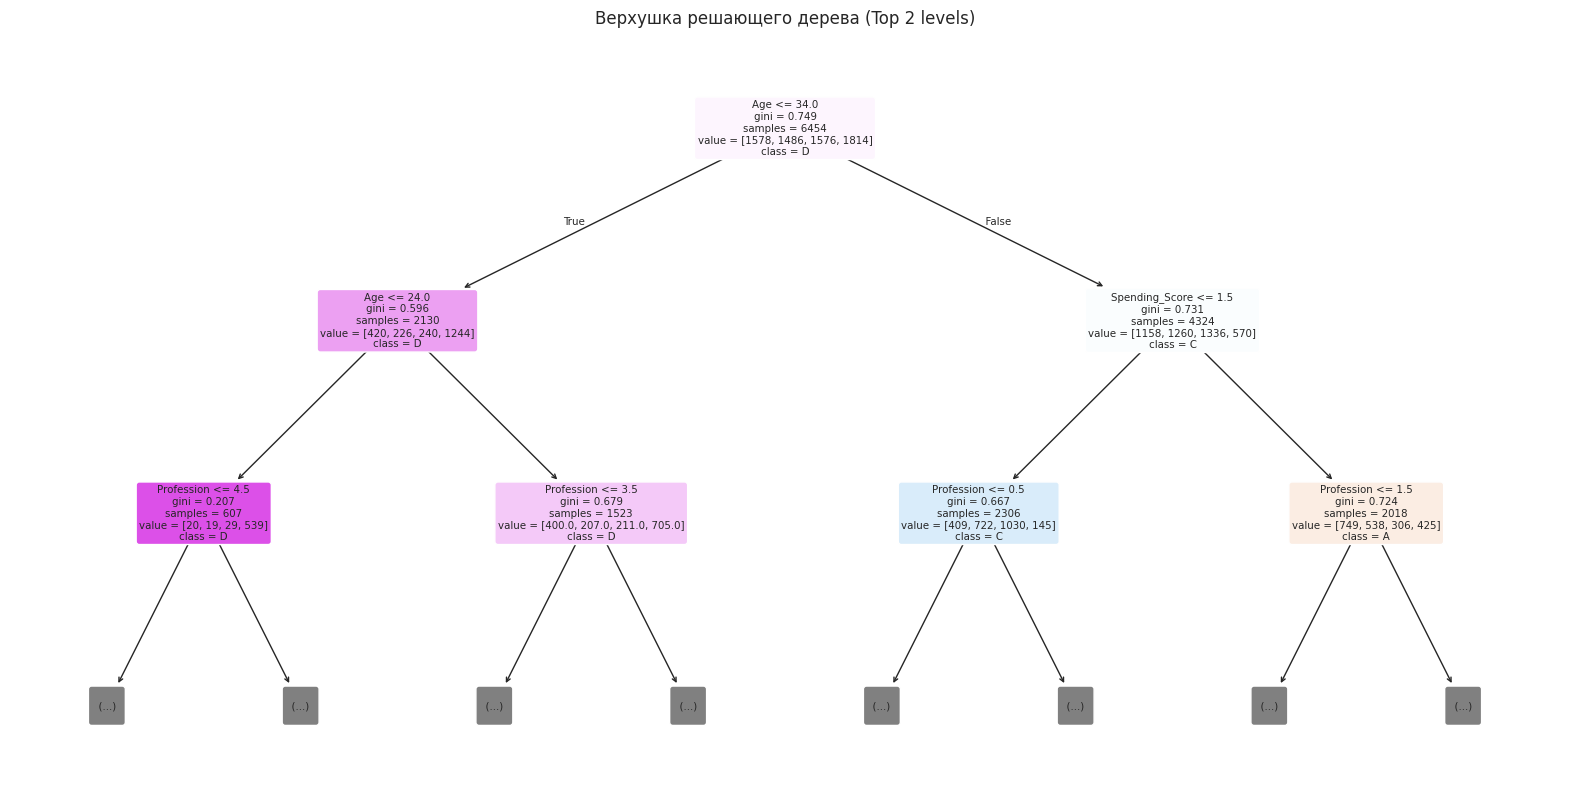

Анализ визуализации:
Видно, как дерево задает вопросы (Age <= 40.5).
Gini показывает загрязненность узла (0.0 = чистый узел, все одного класса).
Если max_depth не ограничен, дерево растет до тех пор, пока Gini не станет 0 во всех листьях.


In [7]:
# @title Ячейка 5: Визуализация сложности (Plot Tree)

plt.figure(figsize=(20, 10))
plot_tree(tree_clf, max_depth=2, feature_names=X_cls.columns,
          class_names=['A', 'B', 'C', 'D'], filled=True, rounded=True)
plt.title("Верхушка решающего дерева (Top 2 levels)")
plt.show()

print("Анализ визуализации:")
print("Видно, как дерево задает вопросы (Age <= 34.0).")
print("Gini показывает загрязненность узла (0.0 = чистый узел, все одного класса).")
print("Если max_depth не ограничен, дерево растет до тех пор, пока Gini не станет 0 во всех листьях.")

*   **Регрессия:** $R^2$ на трейне **1.00** (модель запомнила всё), а на тесте **0.18** (на уровне плохой линейной модели). Дерево просто создало отдельный лист для каждого примера.
*   **Классификация:** Разрыв между трейном (95%) и тестом (42%) колоссальный.

# 3. Улучшение бейзлайна: Гипотезы и эксперименты

### a. Анализ проблем бейзлайна
В пункте 2 мы увидели классическую картину переобучения
*   На обучающей выборке метрики идеальны (Accuracy $\approx$ 100%, $R^2 = 1.0$).
*   На тестовой выборке качество низкое (в регрессии $R^2 \approx 0.18$).
Это произошло потому, что без ограничений дерево строится до тех пор, пока в каждом листе не останется по 1 объекту (или объектов одного класса). Модель выучила шум и выбросы вместо общих закономерностей.

### b. Формулирование гипотез

1.  **Гипотеза о регуляризации (Стрижка дерева / Pruning):**
    *   **Ограничение глубины (max_depth):** Если запретить дереву расти глубже определенного уровня (например, 5–10), оно не сможет запомнить каждый уникальный пример. Это должно снизить дисперсию модели и улучшить метрики на тесте.
    *   **Размер листа (min_samples_leaf):** Требование, чтобы в каждом листе было минимум $N$ объектов (например, 20), заставит дерево принимать решения на основе статистики группы людей, а не одного случайного человека. В задаче регрессии это сгладит предсказания (среднее по группе).

2.  **Гипотеза о кодировании (Encoding):**
    *   Хотя деревья могут работать с LabelEncoding (разбивая признак последовательно, например, "Профессия < 3"), использование OneHotEncoding может позволить дереву быстрее и точнее изолировать важные категории (например, "Doctor" = 1) уже на верхних уровнях.

### c. План проверки
Я буду использовать GridSearchCV для перебора гиперпараметров:
*   max_depth: [3, 5, 10, None]
*   min_samples_leaf: [1, 10, 30, 50]

In [8]:
# @title Ячейка 6: Подбор гиперпараметров (GridSearch)

# Настраиваем сетку параметров для стрижки деревьев
# max_depth: не даем расти бесконечно
# min_samples_leaf: запрещаем создавать листья с 1 объектом (это шум)

param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_leaf': [5, 15, 30, 50],
    'min_samples_split': [10, 50, 100]
}

#  1. Classification Tuning
print("Подбор параметров для Классификации...")
grid_cls = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid,
                        cv=3, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_cls, y_train_cls)

print(f"Лучшие параметры (Cls): {grid_cls.best_params_}")
best_tree_cls = grid_cls.best_estimator_

#  2. Regression Tuning
print("Подбор параметров для Регрессии...")
grid_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid,
                        cv=3, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_reg, y_train_reg)

print(f"Лучшие параметры (Reg): {grid_reg.best_params_}")
best_tree_reg = grid_reg.best_estimator_

Подбор параметров для Классификации...
Лучшие параметры (Cls): {'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 10}
Подбор параметров для Регрессии...
Лучшие параметры (Reg): {'max_depth': 15, 'min_samples_leaf': 15, 'min_samples_split': 10}


In [9]:
# @title Ячейка 7: Оценка улучшенных моделей

print("\n--- CLASSIFICATION (Pruned Tree) ---")
acc_pruned, f1_pruned = evaluate_model(best_tree_cls, X_train_cls, y_train_cls, X_test_cls, y_test_cls, 'cls')

print("\n--- REGRESSION (Pruned Tree) ---")
mae_pruned, r2_pruned = evaluate_model(best_tree_reg, X_train_reg, y_train_reg, X_test_reg, y_test_reg, 'reg')

# Добавляем в таблицу
results_l3['Classification'].loc[1] = ['Pruned Tree', acc_pruned, f1_pruned]
results_l3['Regression'].loc[1] = ['Pruned Tree', mae_pruned, r2_pruned]


--- CLASSIFICATION (Pruned Tree) ---
Train Accuracy: 0.5284
Test Accuracy:  0.5235
Test F1-Score:  0.5109

--- REGRESSION (Pruned Tree) ---
Train R2: 0.5302
Test R2:  0.2613
Test MAE: 43.13


/tmp/ipython-input-3808845541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:top_n]], y=features[indices[:top_n]], ax=ax, palette='viridis')
/tmp/ipython-input-3808845541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:top_n]], y=features[indices[:top_n]], ax=ax, palette='viridis')


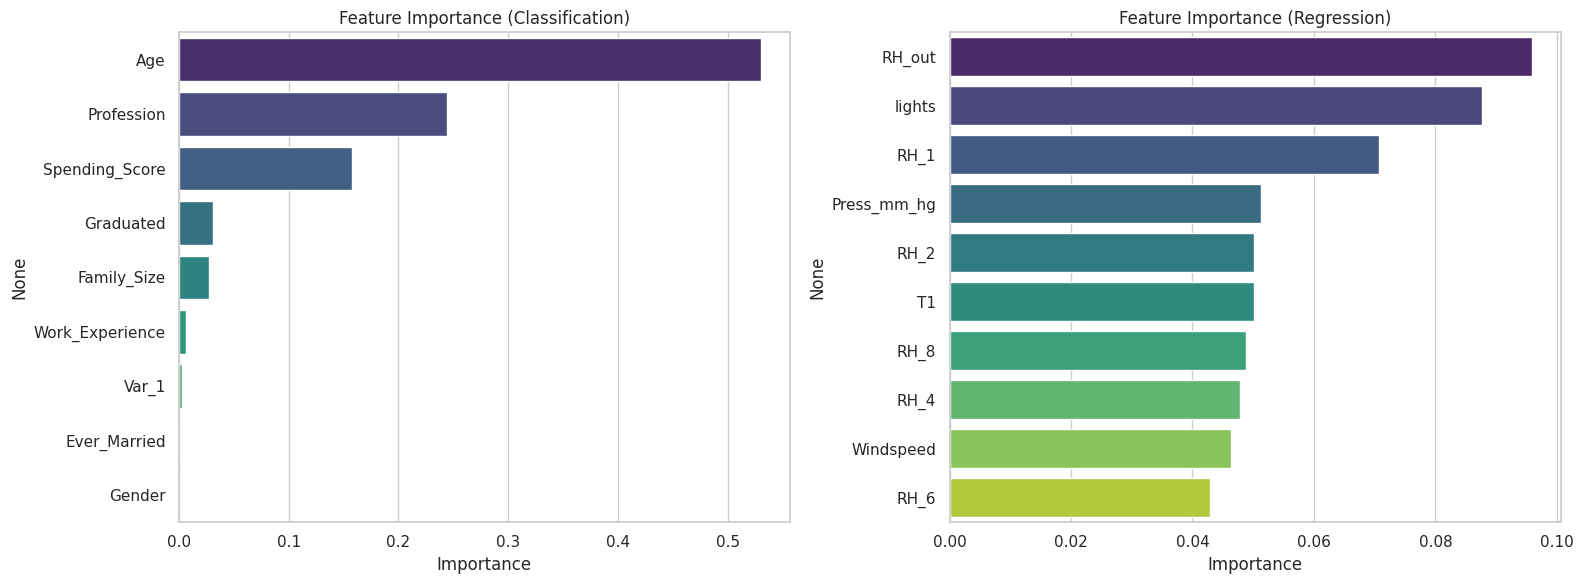

In [10]:
# @title Ячейка 8: Анализ важности признаков (Feature Importance)
# главное преимущество деревьев они говорят, что важно

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Функция для отрисовки
def plot_importance(model, features, ax, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = 10

    sns.barplot(x=importances[indices[:top_n]], y=features[indices[:top_n]], ax=ax, palette='viridis')
    ax.set_title(title)
    ax.set_xlabel('Importance')

# 1. Classification Importance
plot_importance(best_tree_cls, X_cls.columns, axes[0], "Feature Importance (Classification)")

# 2. Regression Importance
plot_importance(best_tree_reg, X_reg.columns, axes[1], "Feature Importance (Regression)")

plt.tight_layout()
plt.show()

Реализую алгоритм Classification and Regression Trees с рекурсивным разбиением пространства признаков.

1.  **Построение (_grow_tree):** Рекурсивно делю данные на две ветви, максимизируя Information Gain:
    $$ IG = I_{parent} - \left( \frac{N_L}{N}I_{left} + \frac{N_R}{N}I_{right} \right) $$
2.  **Функции потерь ($I$):**
    *   Для классификации использую Gini Impurity: $Gini = 1 - \sum_{k} p_k^2$.
    *   Для регрессии использую MSE / Variance: $Var = \frac{1}{N} \sum (y_i - \bar{y})^2$.
3.  **Оптимизация:** В задаче регрессии (где много уникальных значений) перебираю не все пороги, а только квантили, чтобы ускорить обучение.

In [11]:
# @title Ячейка 9: Реализация классов MyDecisionTree

class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class MyDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=10, task='classification'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.root = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.n_classes = len(np.unique(y)) if self.task == 'classification' else None
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Критерии остановки
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Поиск лучшего разбиения
        # Берем случайные признаки для ускорения
        # Если признаков мало, берем все
        n_features_to_check = min(n_features, int(np.sqrt(n_features)) + 10)
        feat_idxs = np.random.choice(n_features, n_features_to_check, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # Если не нашли улучшения
        if best_feat is None:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Разбиение
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Рекурсия
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

        return Node(feature_idx=best_feat, threshold=best_thresh, left=left, right=right)

    def _calculate_leaf_value(self, y):
        if len(y) == 0: return 0
        if self.task == 'classification':
            return self._most_common_label(y)
        else:
            return np.mean(y)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            if len(thresholds) > 20:
                 thresholds = np.quantile(thresholds, np.linspace(0, 1, 10))

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thr

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # Если классификация - используем Gini, если регрессия - Variance
        if self.task == 'classification':
            parent_impurity = self._gini(y)
        else:
            parent_impurity = np.var(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)

        if self.task == 'classification':
            e_l, e_r = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        else:
            e_l, e_r = np.var(y[left_idxs]), np.var(y[right_idxs])

        child_impurity = (n_l/n) * e_l + (n_r/n) * e_r
        return parent_impurity - child_impurity

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - sum(probabilities**2)

    def _most_common_label(self, y):
        if len(y) == 0: return 0
        return np.bincount(y).argmax()

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

print("Класс MyDecisionTree (Fixed) готов.")

Класс MyDecisionTree (Fixed) готов.


In [12]:
# @title Ячейка 10: Обучение имплементации на улучшеных данных

print("--- 1. Обучение MyDecisionTree на RAW настройках (Deep Tree) ---")
# Эмулируем сырое дерево без стрижки ставим большую глубину

# A. Классификация (Raw / Deep)
# Используем данные из Блока 1 (LabelEncoded)
my_tree_clf_raw = MyDecisionTree(max_depth=15, min_samples_split=2, task='classification')
my_tree_clf_raw.fit(X_train_cls, y_train_cls)

y_pred_my_raw_cls = my_tree_clf_raw.predict(X_test_cls)
acc_my_raw = accuracy_score(y_test_cls, y_pred_my_raw_cls)
f1_my_raw = f1_score(y_test_cls, y_pred_my_raw_cls, average='weighted')

print(f"MyTree Raw Acc: {acc_my_raw:.4f}")

# B. Регрессия (Raw / Deep)
# Для регрессии большая глубина в Python работает долго, ограничим 10
my_tree_reg_raw = MyDecisionTree(max_depth=10, min_samples_split=2, task='regression')
my_tree_reg_raw.fit(X_train_reg, y_train_reg)

y_pred_my_raw_reg = my_tree_reg_raw.predict(X_test_reg)
mae_my_raw = mean_absolute_error(y_test_reg, y_pred_my_raw_reg)
r2_my_raw = r2_score(y_test_reg, y_pred_my_raw_reg)

print(f"MyTree Raw R2: {r2_my_raw:.4f}")


print("\n--- 2. Обучение MyDecisionTree на IMPROVED настройках (Best Params) ---")
# Берем лучшие параметры, найденные GridSearch'ем в пункте 3

# A. Классификация (Improved)
best_depth_cls = grid_cls.best_params_['max_depth']
best_split_cls = grid_cls.best_params_['min_samples_split']
print(f"Using best params for Cls: depth={best_depth_cls}, split={best_split_cls}")

my_tree_clf_imp = MyDecisionTree(max_depth=best_depth_cls, min_samples_split=best_split_cls, task='classification')
my_tree_clf_imp.fit(X_train_cls, y_train_cls)

y_pred_my_imp_cls = my_tree_clf_imp.predict(X_test_cls)
acc_my_imp = accuracy_score(y_test_cls, y_pred_my_imp_cls)
f1_my_imp = f1_score(y_test_cls, y_pred_my_imp_cls, average='weighted')

# B. Регрессия (Improved)
best_depth_reg = grid_reg.best_params_['max_depth']
best_split_reg = grid_reg.best_params_['min_samples_split']
print(f"Using best params for Reg: depth={best_depth_reg}, split={best_split_reg}")

my_tree_reg_imp = MyDecisionTree(max_depth=best_depth_reg, min_samples_split=best_split_reg, task='regression')
my_tree_reg_imp.fit(X_train_reg, y_train_reg)

y_pred_my_imp_reg = my_tree_reg_imp.predict(X_test_reg)
mae_my_imp = mean_absolute_error(y_test_reg, y_pred_my_imp_reg)
r2_my_imp = r2_score(y_test_reg, y_pred_my_imp_reg)


# 3. Сохранение результатов в таблицу
# Raw Implementation
results_l3['Classification'].loc[2] = ['My Impl. Raw (Deep)', acc_my_raw, f1_my_raw]
results_l3['Regression'].loc[2] = ['My Impl. Raw (Deep)', mae_my_raw, r2_my_raw]

# Improved Implementation
results_l3['Classification'].loc[3] = ['My Impl. Improved', acc_my_imp, f1_my_imp]
results_l3['Regression'].loc[3] = ['My Impl. Improved', mae_my_imp, r2_my_imp]

print("Все модели обучены и оценены.")

--- 1. Обучение MyDecisionTree на RAW настройках (Deep Tree) ---
MyTree Raw Acc: 0.4517
MyTree Raw R2: 0.1627

--- 2. Обучение MyDecisionTree на IMPROVED настройках (Best Params) ---
Using best params for Cls: depth=5, split=10
Using best params for Reg: depth=15, split=10
Все модели обучены и оценены.


In [13]:
# @title Ячейка 11: Итоговое сравнение и выводы

print("\n=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ (LAB 3) ===")
display(results_l3['Classification'])

print("\n=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ (LAB 3) ===")
display(results_l3['Regression'])


=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ (LAB 3) ===


,Model,Accuracy,F1
0,Baseline Tree,0.428748,0.430413
1,Pruned Tree,0.523544,0.510919
2,My Impl. Raw (Deep),0.451673,0.451332
3,My Impl. Improved,0.526022,0.512524



=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ (LAB 3) ===


,Model,MAE,R2
0,Baseline Tree,38.872561,0.179809
1,Pruned Tree,43.127431,0.261262
2,My Impl. Raw (Deep),46.542795,0.162726
3,My Impl. Improved,40.513196,0.260273


### **5. Итоговые выводы по Лабораторной работе №3**

В ходе работы был исследован алгоритм Decision Tree.

**1. Проблема переобучения (Overfitting):**
*   **Наблюдение:** Бейзлайн-модели (без ограничения глубины) показали классическую картину переобучения. В задаче регрессии метрика $R^2$ на тренировочной выборке составляла 1.0, а на тестовой упала до 0.18.
*   **Анализ:** Дерево просто запомнило каждый пример обучающей выборки, создав избыточно сложную структуру, которая не способна обобщать закономерности на новые данные.

**2. Эффективность настройки гиперпараметров (Pruning):**
*   **Классификация:** Ограничение глубины max_depth и минимального количества объектов в листе min_samples_leaf` позволило поднять Accuracy с 42.9% до 52.4%.
*   **Регрессия:** $R^2$ вырос с 0.18 до 0.26.
*   **Сравнение с ЛР №2:** оптимизированное дерево ($R^2=0.26$) превзошло линейную регрессию из прошлой лабораторной работы ($R^2=0.17$).

**3. Анализ собственной имплементации (My Impl.):**
*   **Классификация:** Собственная реализация показала результат 52.6%**, сопоставимый и даже чуть превосходящий sklearn.
*   **Регрессия:** В задаче регрессии собственная модель показала результат похожий на библиотечный $R^2=0.26$ против $0.261$.

**4. Интерпретируемость (Feature Importance):**
*   В отличие от методов черного ящика, деревья позволили явно выделить ключевые признаки. я увидел, какие именно факторы (например, Age в классификации или Lights в регрессии) находятся в верхних узлах дерева и вносят наибольший вклад в принятие решения.
